This notebook demonstrates the addition of environmental noise to the simulated genetic values to produce final phenotypes, offering two approaches: user-defined noise with explicit mean and covariance parameters, or heritability-based noise where the environmental variance is automatically scaled based on a specified h² value (demonstrated with h² = [0.25, 0.5]). Throughout the workflow, it normalizes the data, splits phenotypes by causal mutation, and validates the results through variance calculations and histograms to confirm that the simulated noise and phenotypes match the expected statistical properties.

In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.split import split_phenotypes


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation. The bash script below will function as expected given the relative path for the source data file is accurate.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct -p 10 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = np.zeros(2)
cov_1 = np.eye(2) 
model_normal_multi = grg_causal_mutation_model("multivariate normal", mean=mean_1, cov=cov_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal_multi.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [[ 1.18126627 -0.92599597]
 [ 0.94240332 -0.70793704]
 [-0.35165354 -1.53977341]
 ...
 [-0.49939915 -0.73796565]
 [ 0.55582376  1.73919313]
 [ 1.56082023 -0.53601873]]


In [5]:
trait_df_normal_multi = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal_multi, random_seed=1)
sample_nodes_df_multi = additive_effect_sizes(grg_1, trait_df_normal_multi)
individuals = samples_to_individuals(sample_nodes_df_multi)
normalized_individual_multi_normal = normalize_genetic_values(individuals)


First, we will demonstrate how to simulate user-defined noise for multiple causal mutations (if the user does not want to use the h2 heritability feature). In this case, the user must specify the mean and covariance matrix to be used.

In [6]:
std_means = np.array([0, 0])
std_covariances = np.array([[1, 0], [0, 1]])
phenotypes_user_defined_multi_normal = sim_env_noise(individuals, user_defined=True, means=std_means, cov=std_covariances) #simulates noise from the multivariate standard normal distribution with means of zero and an identity matrix for covariance
phenotypes_user_defined_multi_normal_df = phenotypes_user_defined_multi_normal.phenotype_df
phenotypes_user_defined_multi_normal_df

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379            -0.263403   
1                     1              0     -23.087706            -0.956462   
2                     0              1     -19.908226            -0.512823   
3                     1              1     -22.240029             1.238233   
4                     0              2      -9.933216             1.167795   
..                  ...            ...            ...                  ...   
395                   1            197       6.632294            -0.635824   
396                   0            198     -28.121344            -0.475162   
397                   1            198     -17.527029             0.062772   
398                   0            199     -10.601552            -0.047657   
399                   1            199     -13.724777            -0.026989   

     phenotype  
0   -38.205782  
1   -24.044168  
2   -20.421050  
3   -21.001796  
4    -8.765422  
..         ...  
395   5.996471  
396 -28.596507  
397 -17.464257  
398 -10.649209  
399 -13.751766  

[400 rows x 5 columns]

The user can extract the h2 assigned to any phenotype simulation as follows.

In [7]:
user_defined_multi_h2 = phenotypes_user_defined_multi_normal.get_h2()
print(user_defined_multi_h2)

[1.01992162 1.00251532]


In [8]:
split_phenotypes(phenotypes_user_defined_multi_normal_df, return_print=True)

     causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379            -0.263403   
2                     0              1     -19.908226            -0.512823   
4                     0              2      -9.933216             1.167795   
6                     0              3     -16.476328            -1.087585   
8                     0              4     -39.004838             1.437701   
..                  ...            ...            ...                  ...   
390                   0            195     -20.002154            -1.188592   
392                   0            196     -27.360933             0.551692   
394                   0            197     -23.888838            -1.569503   
396                   0            198     -28.121344            -0.475162   
398                   0            199     -10.601552            -0.047657   

     phenotype  
0   -38.205782  
2   -20.421050  
4    -8.7654

In [9]:
split_phenotypes_list = split_phenotypes(phenotypes_user_defined_multi_normal_df, return_list=True)
split_phenotypes_list[0] #the first dataframe

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379            -0.263403   
2                     0              1     -19.908226            -0.512823   
4                     0              2      -9.933216             1.167795   
6                     0              3     -16.476328            -1.087585   
8                     0              4     -39.004838             1.437701   
..                  ...            ...            ...                  ...   
390                   0            195     -20.002154            -1.188592   
392                   0            196     -27.360933             0.551692   
394                   0            197     -23.888838            -1.569503   
396                   0            198     -28.121344            -0.475162   
398                   0            199     -10.601552            -0.047657   

     phenotype  
0   -38.205782  
2   -20.421050  
4    -8.765422  
6   -17.563914  
8   -37.567137  
..         ...  
390 -21.190745  
392 -26.809241  
394 -25.458341  
396 -28.596507  
398 -10.649209  

[200 rows x 5 columns]

In [10]:
split_phenotypes_list[1] #the second dataframe

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
1                     1              0     -23.087706            -0.956462   
3                     1              1     -22.240029             1.238233   
5                     1              2     -30.900956            -0.141829   
7                     1              3     -27.909054            -0.242073   
9                     1              4      10.082859            -0.822650   
..                  ...            ...            ...                  ...   
391                   1            195       0.216175            -0.884719   
393                   1            196     -26.683542             1.348780   
395                   1            197       6.632294            -0.635824   
397                   1            198     -17.527029             0.062772   
399                   1            199     -13.724777            -0.026989   

     phenotype  
1   -24.044168  
3   -21.001796  
5   -31.042786  
7   -28.151127  
9     9.260209  
..         ...  
391  -0.668543  
393 -25.334761  
395   5.996471  
397 -17.464257  
399 -13.751766  

[200 rows x 5 columns]

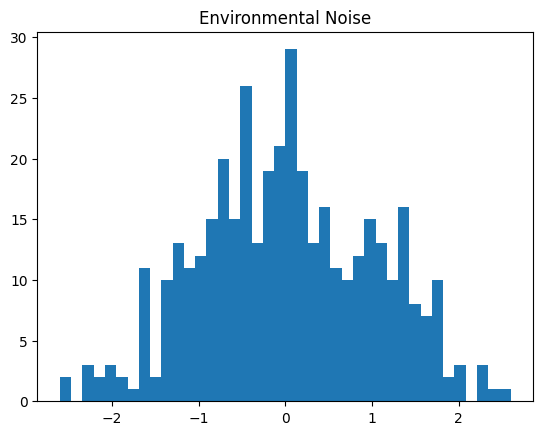

Mean of noise: 0.01754757185193344
Standard deviation of noise: 1.0030443549933517


In [11]:

plt.hist(phenotypes_user_defined_multi_normal_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].std()))

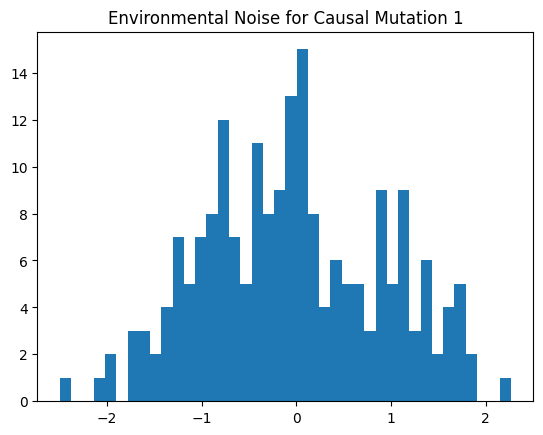

Mean of noise: -0.03442325809802526
Standard deviation of noise: 0.9495791619896607


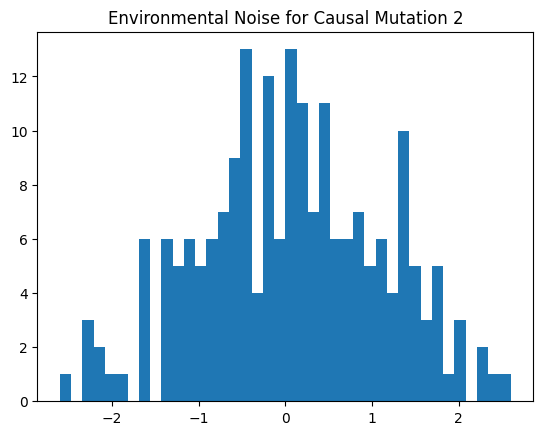

Mean of noise: 0.06951840180189216
Standard deviation of noise: 1.0536233009416298


In [12]:
df_dict_test = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_df.groupby('causal_mutation_id')}

num = len(df_dict_test)

for i in range(num):
  temp_df = df_dict_test[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [13]:
phenotypes_user_defined_multi_normal_df_normalized = normalize(phenotypes_user_defined_multi_normal)
phenotypes_user_defined_multi_normal_df_normalized

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0      -1.481335            -0.021975   
1                     1              0      -0.977564            -0.086005   
2                     0              1       0.249405            -0.045912   
3                     1              1      -0.906505             0.097971   
4                     0              2       1.206708             0.115377   
..                  ...            ...            ...                  ...   
395                   1            197       1.513791            -0.059127   
396                   0            198      -0.538809            -0.042298   
397                   1            198      -0.511426            -0.000566   
398                   0            199       1.142567            -0.001270   
399                   1            199      -0.192693            -0.008090   

     phenotype  
0    -1.503310  
1    -1.063570  
2     0.203493  
3    -0.808535  
4     1.322085  
..         ...  
395   1.454664  
396  -0.581107  
397  -0.511992  
398   1.141297  
399  -0.200783  

[400 rows x 5 columns]

In [14]:
means = np.array([0, 0])
covariance = np.array([[1, 0.25], [0.25, 1]])
phenotypes_user_defined_multi_normal_special_cov = sim_env_noise(individuals, user_defined=True, means=means, cov=covariance) #simulating noise using a user-defined covariance matrix instead of the identity matrix
phenotypes_user_defined_multi_normal_special_cov_df = phenotypes_user_defined_multi_normal_special_cov.phenotype_df
phenotypes_user_defined_multi_normal_special_cov_df

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379             0.387006   
1                     1              0     -23.087706            -1.010666   
2                     0              1     -19.908226            -0.785578   
3                     1              1     -22.240029            -0.461487   
4                     0              2      -9.933216             1.777774   
..                  ...            ...            ...                  ...   
395                   1            197       6.632294             1.101389   
396                   0            198     -28.121344            -0.701323   
397                   1            198     -17.527029            -0.305980   
398                   0            199     -10.601552            -0.224220   
399                   1            199     -13.724777            -1.682133   

     phenotype  
0   -37.555373  
1   -24.098372  
2   -20.693805  
3   -22.701516  
4    -8.155442  
..         ...  
395   7.733684  
396 -28.822667  
397 -17.833009  
398 -10.825772  
399 -15.406910  

[400 rows x 5 columns]

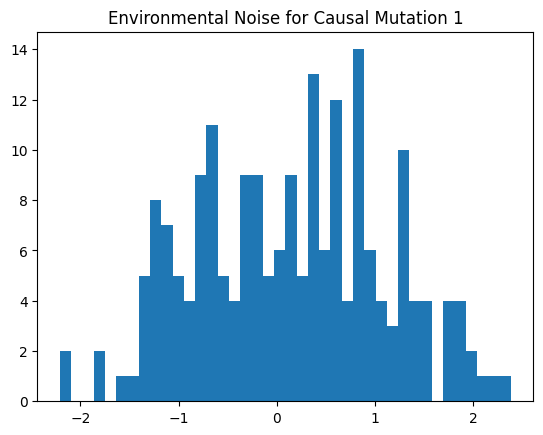

Mean of noise: 0.13833918823386834
Standard deviation of noise: 0.9654389336300733


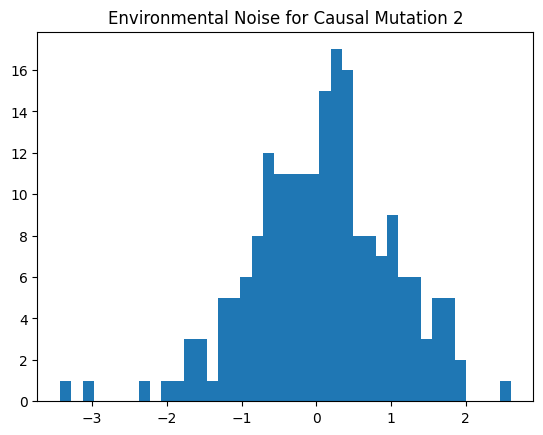

Mean of noise: 0.07675021122142678
Standard deviation of noise: 0.9470585219412644


In [15]:
df_dict_test_cov = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_special_cov_df.groupby('causal_mutation_id')}

num = len(df_dict_test_cov)

for i in range(num):
  temp_df = df_dict_test_cov[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [16]:
phenotypes_user_defined_multi_normal_special_cov_df_normalized = normalize(phenotypes_user_defined_multi_normal_special_cov, normalize_genetic_values=True)
phenotypes_user_defined_multi_normal_special_cov_df_normalized

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0      -1.455713             0.023452   
1                     1              0      -0.978089            -0.091204   
2                     0              1       0.245091            -0.087135   
3                     1              1      -0.906992            -0.045143   
4                     0              2       1.185835             0.154615   
..                  ...            ...            ...                  ...   
395                   1            197       1.514604             0.085939   
396                   0            198      -0.529489            -0.079189   
397                   1            198      -0.511701            -0.032101   
398                   0            199       1.122804            -0.034193   
399                   1            199      -0.192796            -0.147522   

     phenotype  
0    -1.432261  
1    -1.069294  
2     0.157956  
3    -0.952136  
4     1.340451  
..         ...  
395   1.600543  
396  -0.608678  
397  -0.543801  
398   1.088612  
399  -0.340318  

[400 rows x 5 columns]

In [17]:
phenotypes_zero_noise = sim_env_noise(individuals) #simulates zero noise (assumes h2 is an array of 1s)
phenotypes_zero_noise_df = phenotypes_zero_noise.phenotype_df
phenotypes_zero_noise_df

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379                  0.0   
1                     1              0     -23.087706                  0.0   
2                     0              1     -19.908226                  0.0   
3                     1              1     -22.240029                  0.0   
4                     0              2      -9.933216                  0.0   
..                  ...            ...            ...                  ...   
395                   1            197       6.632294                  0.0   
396                   0            198     -28.121344                  0.0   
397                   1            198     -17.527029                  0.0   
398                   0            199     -10.601552                  0.0   
399                   1            199     -13.724777                  0.0   

     phenotype  
0   -37.942379  
1   -23.087706  
2   -19.908226  
3   -22.240029  
4    -9.933216  
..         ...  
395   6.632294  
396 -28.121344  
397 -17.527029  
398 -10.601552  
399 -13.724777  

[400 rows x 5 columns]

Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have not yet been normalized).

In [18]:
phenotype_multi_normal_h2 = sim_env_noise(individuals, h2=[0.5, 0.75]) #simulating environmental noise for 2 causal mutations without normalizing genetic values
phenotype_multi_normal_h2_df = phenotype_multi_normal_h2.phenotype_df
phenotype_multi_normal_h2_df

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379           -15.023463   
1                     1              0     -23.087706           -12.573337   
2                     0              1     -19.908226            15.526725   
3                     1              1     -22.240029             1.194879   
4                     0              2      -9.933216            10.755970   
..                  ...            ...            ...                  ...   
395                   1            197       6.632294             1.379995   
396                   0            198     -28.121344             1.839924   
397                   1            198     -17.527029             0.427444   
398                   0            199     -10.601552             8.390742   
399                   1            199     -13.724777            -4.093358   

     phenotype  
0   -52.965843  
1   -35.661043  
2    -4.381501  
3   -21.045150  
4     0.822753  
..         ...  
395   8.012290  
396 -26.281421  
397 -17.099585  
398  -2.210811  
399 -17.818135  

[400 rows x 5 columns]

In [19]:
print(phenotype_multi_normal_h2.get_h2()) #printing the h2 used for the simulation

[0.5, 0.75]


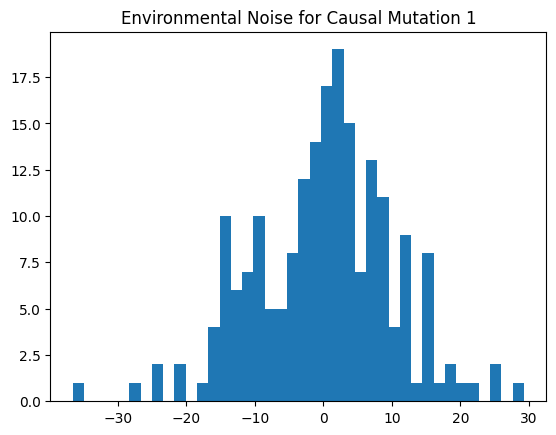

Mean of noise: 0.05736961469501173
Standard deviation of noise: 10.206793853107044


Mean of noise: 0.12143164871960707
Standard deviation of noise: 6.809161981147811


In [20]:
df_dict_test_pre_normal = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal)

for i in range(num):
  temp_df = df_dict_test_pre_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [21]:
phenotype_multi_normal_h2_df_normalized = normalize(phenotype_multi_normal_h2, normalize_genetic_values=True)
phenotype_multi_normal_h2_df_normalized

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0      -1.041136            -1.017221   
1                     1              0      -0.816889            -0.889261   
2                     0              1       0.175291             1.043427   
3                     1              1      -0.757509             0.075194   
4                     0              2       0.848118             0.721634   
..                  ...            ...            ...                  ...   
395                   1            197       1.264980             0.088162   
396                   0            198      -0.378694             0.120236   
397                   1            198      -0.427367             0.021436   
398                   0            199       0.803038             0.562096   
399                   1            199      -0.161021            -0.295244   

     phenotype  
0    -2.058357  
1    -1.706150  
2     1.218718  
3    -0.682315  
4     1.569752  
..         ...  
395   1.353141  
396  -0.258459  
397  -0.405931  
398   1.365134  
399  -0.456265  

[400 rows x 5 columns]

In [22]:
df_dict_test_pre_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df_normalized.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal_final)

for i in range(num):
  temp_df = df_dict_test_pre_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 0.9999999999999997
Variance of the genetic values for Causal Mutation 1 is 0.49971697041401886
Variance of the noise for Causal Mutation 1 is 0.47397866151120377
Variance of the phenotypes for Causal Mutation 2 is 1.0000000000000002
Variance of the genetic values for Causal Mutation 2 is 0.6945981409857289
Variance of the noise for Causal Mutation 2 is 0.2275077633640874


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have already been normalized).

In [23]:
phenotype_post_normalization = sim_env_noise(normalized_individual_multi_normal, h2=[0.25, 0.45]) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization = phenotype_post_normalization.phenotype_df
phenotype_df_post_normalization

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0      -1.472805            -0.296764   
1                     1              0      -0.980158            -1.222731   
2                     0              1       0.247969             1.557319   
3                     1              1      -0.908911             0.939931   
4                     0              2       1.199759            -0.492671   
..                  ...            ...            ...                  ...   
395                   1            197       1.517808            -0.228650   
396                   0            198      -0.535707            -0.139752   
397                   1            198      -0.512783            -1.012115   
398                   0            199       1.135988            -0.900139   
399                   1            199      -0.193204            -1.182677   

     phenotype  
0    -1.769569  
1    -2.202889  
2     1.805288  
3     0.031021  
4     0.707088  
..         ...  
395   1.289158  
396  -0.675459  
397  -1.524898  
398   0.235849  
399  -1.375881  

[400 rows x 5 columns]

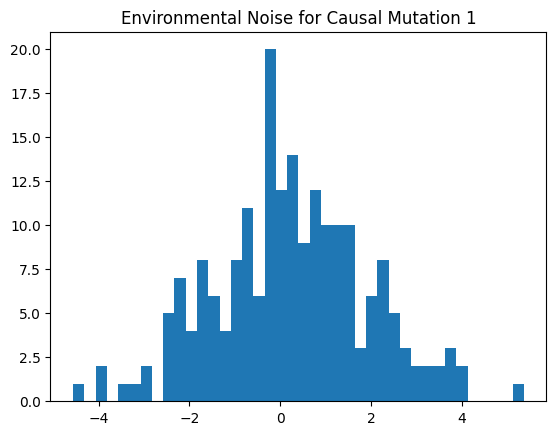

Mean of noise: 0.2219448962943291
Standard deviation of noise: 1.703410453191503


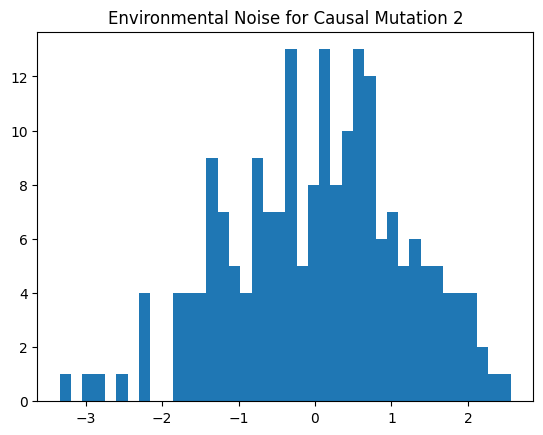

Mean of noise: 0.04288527735635014
Standard deviation of noise: 1.1479262649606103


In [24]:
df_dict_test_post_normal = {k: v.sort_values('individual_id') for k, v in phenotype_df_post_normalization.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal)

for i in range(num):
  temp_df = df_dict_test_post_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_final_df = normalize(phenotype_post_normalization) #normalizing the final dataframe with the phenotypes
phenotype_post_normalization_final_df

causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0      -0.709024            -0.249712   
1                     1              0      -0.635969            -0.821187   
2                     0              1       0.119375             0.642863   
3                     1              1      -0.589741             0.582043   
4                     0              2       0.577576            -0.344023   
..                  ...            ...            ...                  ...   
395                   1            197       0.984820            -0.176184   
396                   0            198      -0.257895            -0.174125   
397                   1            198      -0.332716            -0.684530   
398                   0            199       0.546876            -0.540183   
399                   1            199      -0.125359            -0.795198   

     phenotype  
0    -0.958735  
1    -1.457157  
2     0.762237  
3    -0.007698  
4     0.233553  
..         ...  
395   0.808636  
396  -0.432019  
397  -1.017246  
398   0.006694  
399  -0.920557  

[400 rows x 5 columns]

In [26]:
df_dict_test_post_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_post_normalization_final_df.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal_final)

for i in range(num):
  temp_df = df_dict_test_post_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 1.0
Variance of the genetic values for Causal Mutation 1 is 0.2317558664993159
Variance of the noise for Causal Mutation 1 is 0.672464484397242
Variance of the phenotypes for Causal Mutation 2 is 1.0
Variance of the genetic values for Causal Mutation 2 is 0.42099822261198955
Variance of the noise for Causal Mutation 2 is 0.5547639706942072
